In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import itertools
import statsmodels.formula.api as smf

plt.style.use('ggplot')

In [2]:
data = pd.read_csv("data/processed/all_features.csv", index_col=0)
df = pd.read_pickle("data/processed/finbert_probs_only_qa.pkl")

merged_df = pd.merge(df, data, how='left', left_index=True, right_index=True)
merged_df.index.name = 'Index'
merged_df = merged_df.sort_values(['date', 'Index'])
merged_df.columns

Index(['positive', 'negative', 'neutral', 'date', 'exchange', 'q', 'ticker',
       'transcript', 'year', 'time', 'change_sp500_1week',
       'change_sp500_1month', 'change_sp500_3month', 'interest_rate',
       'change_interest_rate_3month', 'change_during_news', 'change_day_after',
       'change_week_after', 'change_month_after', 'past_change_1week',
       'past_change_1month', 'past_change_3month', 'processed_transcript'],
      dtype='object')

In [3]:
# Organize the data (drop neutral since it is the complement of positive and negative)

features_with_sentiment = ['positive','negative',
                           'change_sp500_1week','change_sp500_1month', 'change_sp500_3month', 
                           'interest_rate', 'change_interest_rate_3month', 
                           'past_change_1week', 'past_change_1month', 'past_change_3month']

features_without_sentiment = ['change_sp500_1week','change_sp500_1month', 'change_sp500_3month', 
                           'interest_rate', 'change_interest_rate_3month', 
                           'past_change_1week', 'past_change_1month', 'past_change_3month']


In [4]:
# Initialization
data_work, data_holdout = train_test_split(merged_df, test_size=0.4, shuffle=False, random_state=42)

model_types = ['change_during_news', 'change_day_after', 'change_week_after', 'change_month_after']

# Generate all possible combinations of features
nosentiment_combinations = []
for r in range(1, len(features_without_sentiment) + 1):
    combinations_r = list(itertools.combinations(features_without_sentiment, r))
    nosentiment_combinations.extend(combinations_r)

sentiment_combinations = []
for r in range(1, len(features_with_sentiment) + 1):
    combinations_r = list(itertools.combinations(features_with_sentiment, r))
    sentiment_combinations.extend(combinations_r)

# Model selection criterion
crit = lambda x: x.rsquared_adj


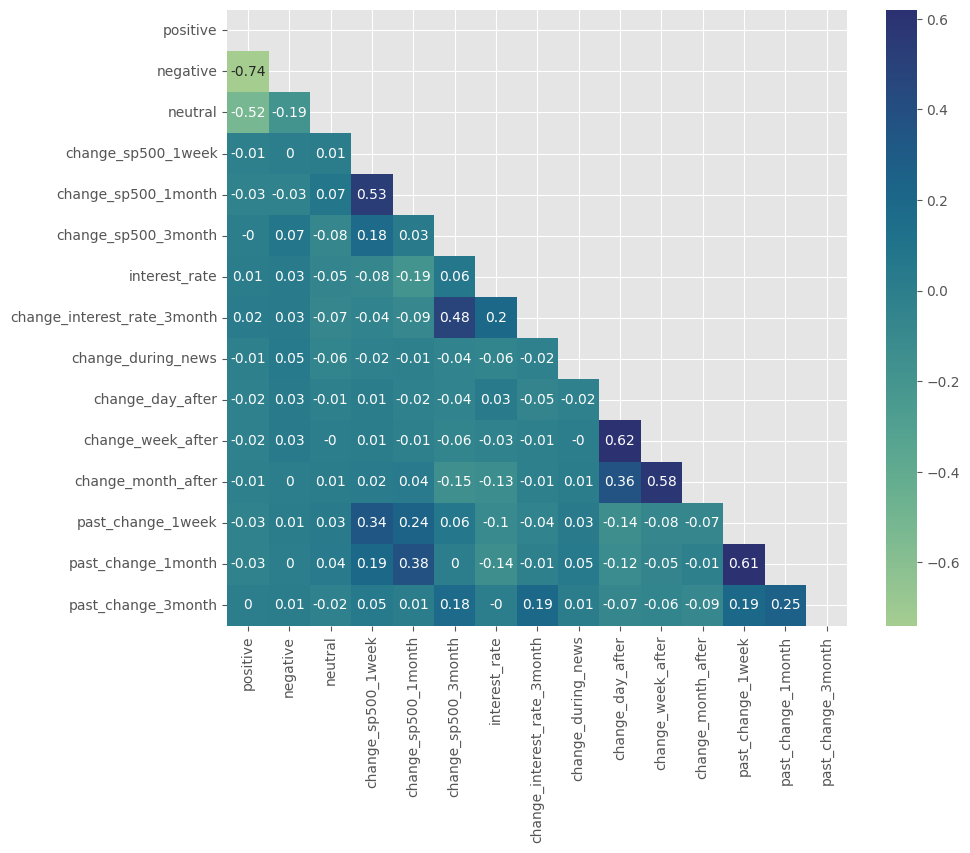

In [5]:
# Correlation matrix
df = data_work.drop(['date', 'exchange', 'q', 'ticker',
                     'transcript', 'year', 'time', 'processed_transcript'], axis=1)
corr = df.corr().round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap="crest")
plt.show()


In [6]:
# Without sentiment: no interaction
nosentiment = []

# Loop over each model type
for model in model_types:
    results = []
    
    # Loop over all feature combinations
    for combination in nosentiment_combinations:
        variables = " + ".join(combination)
        formula = f"{model} ~ {variables}" # first-order model
        reg = smf.ols(formula=formula, data=data_work).fit()
        results.append(reg)
    
    # Select the best model based on crit
    best_reg = max(results, key=crit)
    nosentiment.append(best_reg)


In [7]:
# With sentiment: no interaction
sentiment = []

# Loop over each model type
for model in model_types:
    results = []
    
    # Loop over all feature combinations
    for combination in sentiment_combinations:
        variables = " + ".join(combination)
        formula = f"{model} ~ {variables}" # first-order model
        reg = smf.ols(formula=formula, data=data_work).fit()
        results.append(reg)
    
    # Select the best model based on crit
    best_reg = max(results, key=crit)
    sentiment.append(best_reg)


In [8]:
# Without sentiment: second-order interactions
nosentiment_so = []

# Loop over each model type
for model in model_types:
    results = []
    
    # Loop over all feature combinations
    for combination in nosentiment_combinations:
        variables = " + ".join(combination)
        formula = f"{model} ~ ({variables})**2" # second-order interactions (no squared terms)
        reg = smf.ols(formula=formula, data=data_work).fit()
        results.append(reg)
    
    # Select the best model based on crit
    best_reg = max(results, key=crit)
    nosentiment_so.append(best_reg)


In [9]:
# With sentiment: second-order interactions
sentiment_so = []

# Loop over each model type
for model in model_types:
    results = []
    
    # Loop over all feature combinations
    for combination in sentiment_combinations:
        variables = " + ".join(combination)
        formula = f"{model} ~ ({variables})**2" # second-order interactions (no squared terms)
        reg = smf.ols(formula=formula, data=data_work).fit()
        results.append(reg)
    
    # Select the best model based on crit
    best_reg = max(results, key=crit)
    sentiment_so.append(best_reg)


In [10]:
# Output best training results
for i, model in enumerate(model_types):
    print(f"MODEL: {model}")
    print("\n")
    print("Without sentiment:")
    print(nosentiment[i].summary())
    print("\n")
    print("With sentiment:")
    print(sentiment[i].summary())
    print("\n")
    print("Without sentiment (second-order interactions):")
    print(nosentiment_so[i].summary())
    print("\n")
    print("With sentiment (second-order interactions):")
    print(sentiment_so[i].summary())
    

MODEL: change_during_news


Without sentiment:
                            OLS Regression Results                            
Dep. Variable:     change_during_news   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     11.77
Date:                Thu, 23 May 2024   Prob (F-statistic):           1.59e-09
Time:                        14:24:59   Log-Likelihood:                 8573.5
No. Observations:                6081   AIC:                        -1.714e+04
Df Residuals:                    6076   BIC:                        -1.710e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [11]:
# Trading metric & strategies

# Correct direction percentage
def correct_direction(y_test, predictions):
    same_sign_count = sum((y_test >= 0) == (predictions >= 0))
    total_samples = len(y_test)
    percentage_same_sign = (same_sign_count / total_samples) * 100
    return percentage_same_sign

# Constant investment strategy (1$ per bet)
def sum_returns_strat(y_test, predictions, buy_threshold=0.00, sell_threshold=-0.00):
    money_for_each_bet = 1
    money = 0
    nb_bets = ((predictions > buy_threshold) | (predictions < sell_threshold)).sum()
    for nb, p in enumerate(predictions):
        if p > buy_threshold:
            money += y_test.iloc[nb] * money_for_each_bet
        if p < sell_threshold:
            money -= min(y_test.iloc[nb] * money_for_each_bet, 1)
    return money / nb_bets if nb_bets > 0 else 0

# Proportional investment strategy
def prop_sum_returns_strat(y_test, predictions, buy_threshold=0.00, sell_threshold=-0.00):
    
    total_money = len(predictions)
    sum_pred = np.sum(np.abs(predictions))
    nb_bets = ((predictions > buy_threshold) | (predictions < sell_threshold)).sum()
    money = 0
    for nb, p in enumerate(predictions):
        money_for_the_bet = (np.abs(predictions[nb]) / sum_pred) * total_money
        if p > buy_threshold:
            money += y_test.iloc[nb] * money_for_the_bet
        if p < sell_threshold:
            money -= min(y_test.iloc[nb] * money_for_the_bet, money_for_the_bet)
    return  money / nb_bets if nb_bets > 0 else 0

# Strongest sentiment strategy (percentile)
def best_sent_strat(y_test, X_test, predictions, percentile=5):
    # Calculate the score difference
    score_diff = X_test['positive'] - X_test['negative']
    
    # Determine the 5th and 95th percentiles
    lower_bound = np.percentile(score_diff, percentile)
    upper_bound = np.percentile(score_diff, 100-percentile)
    
    # Initialize the variables
    money_for_each_bet = 1
    money = 0
    nb_bets = 0
    
    for nb, p in enumerate(predictions):
        # Check if the current score difference is within the desired percentiles
        if score_diff.iloc[nb] > lower_bound and score_diff.iloc[nb] < upper_bound:
            # Continue if not within the 5th or 95th percentile bounds
            continue
        
        # Trade if the prediction is above the buy threshold
        if score_diff.iloc[nb] > upper_bound:
            money += y_test.iloc[nb] * money_for_each_bet
            nb_bets += 1
        
        # Trade if the prediction is below the sell threshold
        if score_diff.iloc[nb] < lower_bound:
            money -= min(y_test.iloc[nb] * money_for_each_bet, 1)
            nb_bets += 1
    
    # Return the average money per bet or 0 if no bets were made
    return money / nb_bets if nb_bets > 0 else 0

In [13]:
# Fit models and evaluate on the test set
for i, model in enumerate(model_types):

    # Create list of corresponding regressions
    model_list = [(nosentiment[i], "Without sentiment"),
                  (sentiment[i], "With sentiment"),
                  (nosentiment_so[i], "Without sentiment (second-order interactions)"),
                  (sentiment_so[i], "With sentiment (second-order interactions)")]

    # Select the test set based on model
    y_test = data_holdout[f"{model}"]
    X_test = data_holdout[features_with_sentiment] # needed for best_sent_strat
    
    print(f"MODEL: {model}" + "\n")

    for model_instance, description in model_list:
        # Make predictions on the test set
        pred = model_instance.get_prediction(data_holdout).predicted_mean
        direction = correct_direction(y_test, pred)
        
        # Extract adjusted R-squared on the training set
        adj_r_train = model_instance.rsquared_adj

        # # Compute adjusted R-squared on the test set
        # n = len(y_test)
        # p = model_instance.df_model + 1  # Number of predictors plus the intercept
        # rss = ((y_test - pred) ** 2).sum()  # Residual sum of squares
        # tss = ((y_test - y_test.mean()) ** 2).sum()  # Total sum of squares
        # r_squared = 1 - (rss / tss)
        # adj_r_test = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))

        # Compute Root Mean Squared Error (RMSE)
        n = len(y_test)
        rss = ((y_test - pred) ** 2).sum()  # Residual sum of squares
        rmse = (rss / n) ** 0.5

        print(f"{description}:")
        print(f"Adj R2 on train: {adj_r_train:.4f}")
        # print(f"Adj R2 on test: {adj_r_test:.4f}")
        print(f"RMSE on test: {rmse:.4f}")
        print(f"Correct direction: {direction:.2f}%")
        print(f"Sum of returns: {sum_returns_strat(y_test, pred):.4f}")
        print(f"Prop sum of returns: {prop_sum_returns_strat(y_test, pred):.4f}")
    
        if description == "With sentiment" or description == "With sentiment (second-order interactions)":
            print(f"Strongest sentiment strategy: {best_sent_strat(y_test, X_test, pred):.4f}")

        print("\n")


MODEL: change_during_news

Without sentiment:
Adj R2 on train: 0.0070
RMSE on test: 0.0795
Correct direction: 49.28%
Sum of returns: -0.0017
Prop sum of returns: -0.0043


With sentiment:
Adj R2 on train: 0.0129
RMSE on test: 0.0792
Correct direction: 51.68%
Sum of returns: 0.0018
Prop sum of returns: 0.0031
Strongest sentiment strategy: -0.0085


Without sentiment (second-order interactions):
Adj R2 on train: 0.0166
RMSE on test: 0.0814
Correct direction: 49.56%
Sum of returns: 0.0007
Prop sum of returns: -0.0000


With sentiment (second-order interactions):
Adj R2 on train: 0.0251
RMSE on test: 0.0812
Correct direction: 52.44%
Sum of returns: 0.0040
Prop sum of returns: 0.0039
Strongest sentiment strategy: -0.0085


MODEL: change_day_after

Without sentiment:
Adj R2 on train: 0.0292
RMSE on test: 0.0715
Correct direction: 51.78%
Sum of returns: 0.0034
Prop sum of returns: 0.0070


With sentiment:
Adj R2 on train: 0.0299
RMSE on test: 0.0715
Correct direction: 51.95%
Sum of returns: 0